In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from scipy.stats import zscore, uniform
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from math import sqrt

import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

from sklearn.model_selection import train_test_split

In [2]:
# read data
airbnb_ny = pd.read_csv('../data/raw_data.csv')
# drop features
airbnb_ny.drop(['id','name', 'host_id', 'host_name','last_review'], axis=1, inplace=True)
# fill nas in reviews per month
airbnb_ny = airbnb_ny.fillna({'reviews_per_month':0})
# split to X and Y
X = airbnb_ny.drop(['price'], axis=1)
y = airbnb_ny.price
# split to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [3]:
# combine X and y for test and train respectively
full_train = pd.concat((X_train, y_train), axis= 1)
full_test = pd.concat((X_test, y_test), axis= 1)

In [4]:
full_train.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
21838,Manhattan,East Village,40.72208,-73.98109,Private room,1,116,4.07,2,238,73
47539,Manhattan,Nolita,40.72206,-73.99695,Entire home/apt,4,0,0.00,1,317,189
25386,Staten Island,Fort Wadsworth,40.59546,-74.06092,Entire home/apt,7,0,0.00,3,365,800
24173,Manhattan,Upper East Side,40.77854,-73.94984,Entire home/apt,31,7,0.30,33,345,265
27875,Brooklyn,Bedford-Stuyvesant,40.69854,-73.94069,Private room,2,4,0.21,1,0,50


In [5]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39116 entries, 21838 to 33003
Data columns (total 11 columns):
neighbourhood_group               39116 non-null object
neighbourhood                     39116 non-null object
latitude                          39116 non-null float64
longitude                         39116 non-null float64
room_type                         39116 non-null object
minimum_nights                    39116 non-null int64
number_of_reviews                 39116 non-null int64
reviews_per_month                 39116 non-null float64
calculated_host_listings_count    39116 non-null int64
availability_365                  39116 non-null int64
price                             39116 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 3.6+ MB


In [6]:
full_train.shape

(39116, 11)

In [7]:
X_train = full_train.drop(['price'], axis=1)
y_train = full_train['price']
X_test = full_test.drop(['price'], axis=1)
y_test = full_test['price']

In [8]:
categorical_features = [
  'neighbourhood_group', 
  'neighbourhood',
  'room_type'
]

In [9]:
for feature in categorical_features:
  le = LabelEncoder()
  le.fit(X_train[feature])
  X_train[feature] = le.transform(X_train[feature])
  X_test[feature] = le.transform(X_test[feature])

In [10]:
X_train.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
21838,2,64,40.72208,-73.98109,1,1,116,4.07,2,238
47539,2,145,40.72206,-73.99695,0,4,0,0.00,1,317
25386,4,82,40.59546,-74.06092,0,7,0,0.00,3,365
24173,2,201,40.77854,-73.94984,0,31,7,0.30,33,345
27875,1,13,40.69854,-73.94069,1,2,4,0.21,1,0


In [11]:
y_train

21838     73
47539    189
25386    800
24173    265
27875     50
        ... 
43723     60
32511    157
5192     115
12172    330
33003     60
Name: price, Length: 39116, dtype: int64

In [12]:
null_model = DummyRegressor(strategy='median')

In [13]:
null_model.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='median')

The MSE of the null model is:

In [14]:
mean_absolute_error(y_test, null_model.predict(X_test))

83.20462214950403

In [16]:
random_forest_tuning_parameters = {
  'max_depth': [10, 50],
  'min_samples_split': [5, 20],
  'n_estimators': [600, 1500],
  'criterion': ['mse'],
  'random_state': [0]
}

In [17]:
rf = GridSearchCV(
  estimator=RandomForestRegressor(random_state=random_state), 
  param_grid=random_forest_tuning_parameters, 
  cv=4, 
  verbose=2,
  n_jobs=-1,
  scoring='neg_mean_absolute_error'
)

In [18]:
rf.fit(X_train, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 12.9min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [

In [19]:
def print_model_info(grid_model, model_name):
  print(model_name + ' info:')
  print('')
  print('MAE:')
  print(mean_absolute_error(y_test, grid_model.best_estimator_.predict(X_test)))
  print('')
  print('Best params: ')
  print(grid_model.best_params_)
  feature_importantance_series = pd.Series(grid_model.best_estimator_.feature_importances_)
  feature_importantance_series.index = X_test.columns
  print('')
  print('Feature importance:')
  print(feature_importantance_series.sort_values(ascending=False))

In [20]:
print_model_info(rf, 'Random Forest Regressor')

Random Forest Regressor info:

MAE:
65.3525494406265

Best params: 
{'criterion': 'mse', 'max_depth': 50, 'min_samples_split': 20, 'n_estimators': 1500}

Feature importance:
longitude                         0.288875
latitude                          0.171414
room_type                         0.126948
availability_365                  0.100872
calculated_host_listings_count    0.085693
neighbourhood                     0.077801
minimum_nights                    0.071719
reviews_per_month                 0.045339
number_of_reviews                 0.027207
neighbourhood_group               0.004131
dtype: float64


In [45]:
light_regressor_tuning_parameters = {
  'min_data_in_leaf': [100, 300, 500, 1000, 1500],
  'num_leaves': [15, 30, 40, 50, 60],
  'max_depth': [15, 30, 45],
  'random_state': [0]
}

In [46]:
light_reg = GridSearchCV(
  estimator=LGBMRegressor(), 
  param_grid=light_regressor_tuning_parameters, 
  cv=4, 
  verbose=2,
  n_jobs=-1,
  scoring='neg_mean_absolute_error'
)

In [47]:
light_reg.fit(X_train, y_train, eval_metric='l1')

Fitting 4 folds for each of 75 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   31.4s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [15, 30, 45],
                         'min_data_in_leaf': [100, 300, 500, 1000, 1500],
                         'num_leaves': [15, 30

In [48]:
print_model_info(light_reg, 'LightGBM Regressor')

LightGBM Regressor info:

MAE:
65.79249854834946

Best params: 
{'max_depth': 15, 'min_data_in_leaf': 100, 'num_leaves': 15, 'random_state': 0}

Feature importance:
minimum_nights                    254
latitude                          218
longitude                         211
availability_365                  210
calculated_host_listings_count    182
reviews_per_month                  95
number_of_reviews                  87
neighbourhood                      79
room_type                          60
neighbourhood_group                 4
dtype: int32


In [25]:
xgb_regressor_tuning_parameters = { 
  'max_depth': [5, 7, 10],
  'colsample_bytree': [0.6, 0.7, 0.8],
  'n_estimators': [500, 1000],
  'random_state': [0]
}

In [26]:
xgb_reg = GridSearchCV(
  estimator=XGBRegressor(), 
  param_grid=xgb_regressor_tuning_parameters, 
  cv=4, 
  verbose=2,
  n_jobs=-1,
  scoring='neg_mean_absolute_error'
)

In [27]:
xgb_reg.fit(X_train, y_train, eval_metric='mae')

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  8.4min finished
/Users/jackyho/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/jackyho/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:07:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'max_depth': [5, 7, 10], 'n_estimator

In [28]:
print_model_info(xgb_reg, 'XGBoost Regressor')

XGBoost Regressor info:

MAE:
65.45117289039399

Best params: 
{'colsample_bytree': 0.7, 'max_depth': 5, 'n_estimators': 500}

Feature importance:
longitude                         0.283776
room_type                         0.176409
calculated_host_listings_count    0.097178
neighbourhood_group               0.094955
neighbourhood                     0.084899
latitude                          0.079692
minimum_nights                    0.054002
number_of_reviews                 0.044417
availability_365                  0.043061
reviews_per_month                 0.041611
dtype: float32


In [29]:
test_average_ensemble_prediction = np.average([
  rf.best_estimator_.predict(X_test),
  light_reg.best_estimator_.predict(X_test),
  xgb_reg.best_estimator_.predict(X_test)
], axis=0)

In [30]:
mean_absolute_error(y_test, test_average_ensemble_prediction)

63.93848471184588

In [31]:
ensemble_residual_df = pd.DataFrame({
  'true_price': y_test,
  'average_ensemble_residual': y_test - test_average_ensemble_prediction
})

In [32]:
residual_chart = alt.Chart(ensemble_residual_df).mark_circle(size=30, opacity=0.4).encode(
  x=alt.X('true_price', title='Price'),
  y=alt.Y('average_ensemble_residual', title='Average ensembling residual')
).properties(
  width=850,
  height=500
).properties(
  title='Average Ensembling Residuals on Test Data'
)

In [33]:
residual_dist_chart = alt.Chart(ensemble_residual_df).mark_bar().encode(
  x=alt.X(
    'average_ensemble_residual', 
    title='Average ensembling residual', 
    bin=alt.Bin(extent=[-1200, 2000], step=5)
  ),
  y='count()'
).properties(
  width=850,
  height=500
).properties(
  title='Ensembling Residual Distribution'
)

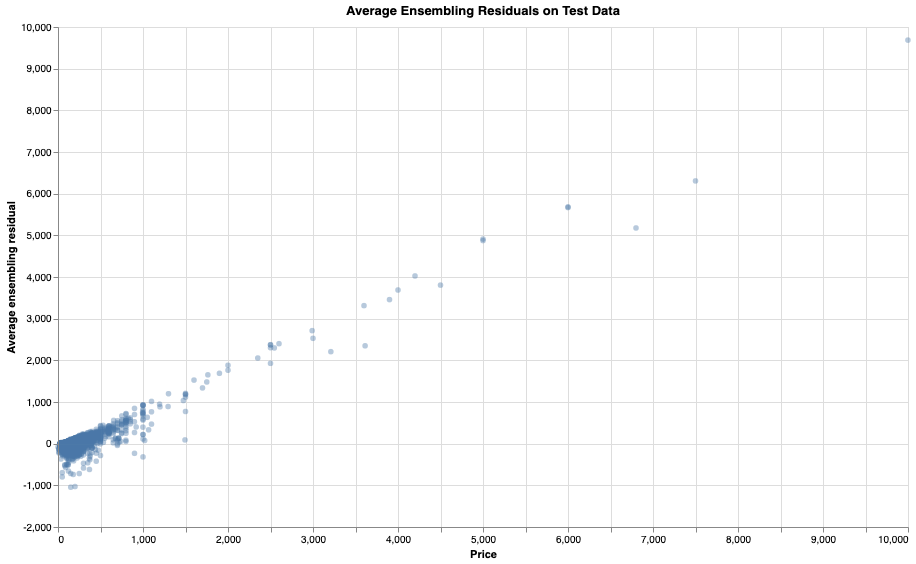

In [34]:
residual_chart

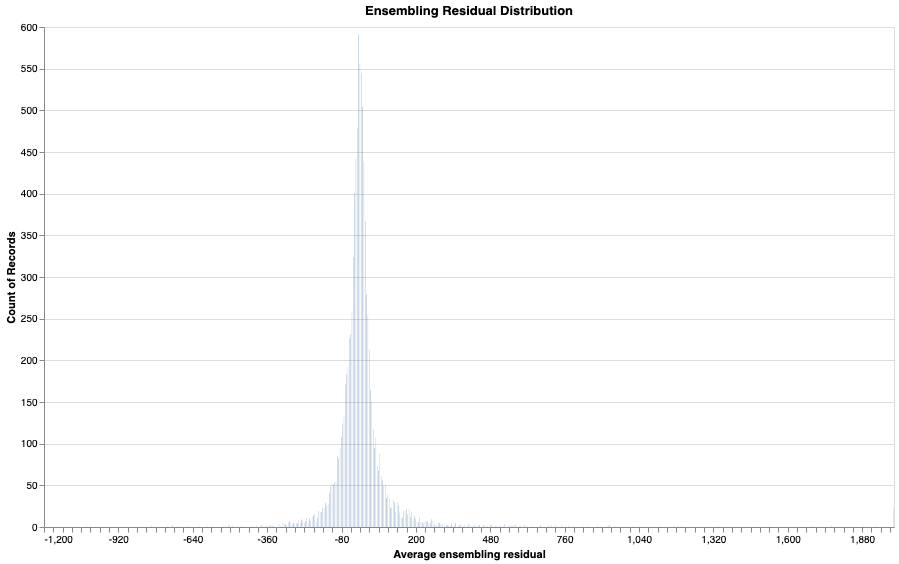

In [35]:
residual_dist_chart

In [36]:
with alt.data_transformers.enable('default'):
    residual_chart.save("../results/plots/ensemble_residual_plot.png")
    residual_dist_chart.save("../results/plots/ensemble_residual_distribution.png")

In [37]:
feature_important_df = pd.DataFrame({
  'Random Forest': rf.best_estimator_.feature_importances_,
  'XGBoost': xgb_reg.best_estimator_.feature_importances_,
  'LightGBM': light_reg.best_estimator_.feature_importances_/sum(light_reg.best_estimator_.feature_importances_)
})

feature_important_df.index = X_test.columns

feature_important_df

,Random Forest,XGBoost,LightGBM
neighbourhood_group,0.004131,0.094955,0.002857
neighbourhood,0.077801,0.084899,0.056429
latitude,0.171414,0.079692,0.155714
longitude,0.288875,0.283776,0.150714
room_type,0.126948,0.176409,0.042857
minimum_nights,0.071719,0.054002,0.181429
number_of_reviews,0.027207,0.044417,0.062143
reviews_per_month,0.045339,0.041611,0.067857
calculated_host_listings_count,0.085693,0.097178,0.130000
availability_365,0.100872,0.043061,0.150000


In [40]:
train_average_ensemble_prediction = np.average([
  rf.best_estimator_.predict(X_train),
  light_reg.best_estimator_.predict(X_train),
  xgb_reg.best_estimator_.predict(X_train)
], axis=0)

mean_absolute_error_df = pd.DataFrame({
  'train_mean_absolute_error': [
    mean_absolute_error(y_train, null_model.predict(X_train)),
    mean_absolute_error(y_train, rf.predict(X_train)),
    mean_absolute_error(y_train, xgb_reg.predict(X_train)),
    mean_absolute_error(y_train, light_reg.predict(X_train)),
    mean_absolute_error(y_train, train_average_ensemble_prediction),  
  ],
  'test_mean_absolute_error': [
    mean_absolute_error(y_test, null_model.predict(X_test)),
    mean_absolute_error(y_test, rf.predict(X_test)),
    mean_absolute_error(y_test, xgb_reg.predict(X_test)),
    mean_absolute_error(y_test, light_reg.predict(X_test)),
    mean_absolute_error(y_test, test_average_ensemble_prediction),  
  ]
})

mean_absolute_error_df.index = [
  'Median Null Model',
  'Random Forest', 
  'XGBoost', 
  'LightGBM', 
  'Average Ensembling'
]

In [41]:
mean_absolute_error_df

,train_mean_absolute_error,test_mean_absolute_error
Median Null Model,84.317492,83.204622
Random Forest,46.710278,65.352549
XGBoost,53.081154,65.451173
LightGBM,64.045905,65.792499
Average Ensembling,53.269785,63.938485


In [43]:
mean_absolute_error_df.to_csv("../results/tables/mean_absolute_error_table.csv")

In [44]:
feature_important_df.to_csv('../results/tables/feature_importance_table.csv')